In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import cv2
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3Dv2, Tree3D
from tree_segmentation.render import choose_best_views, random_camera_position
from paper.paper_util import get_2d_tree_from_3d
from evaluation.eval_Replica import load_mesh_and_gt, load_images
import open3d as o3d


/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-19 17:35:47.478552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 17:35:48.386707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-19 17:35:48.386868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.1+cu117


In [3]:
data_root = Path('~/data/Replica').expanduser()
scene = 'room_2'
data_dir = data_root.joinpath(scene)
print('data direcotry:', data_dir)
mesh_path = data_dir.joinpath('simplify.ply')
cache_dir = Path(f'./results/Replica_3/{scene}')
# cache_dir.mkdir(exist_ok=True)
print('cache dir:', os.listdir(cache_dir))

data direcotry: /home/wan/data/Replica/room_2
cache dir: ['X.pth', 'A.pth', 'my.tree3dv2', 'images', 'n10000.tree3dv2', 'gt.tree3dv2', 'log_08-15_04:46:19.txt', '08_19', 'log_08-16_18:43:47.txt']


In [4]:
mesh, gt = load_mesh_and_gt(data_dir, cache_dir)
mesh = mesh.to(device).unit_size()
roate_angle = {
    'office_0': 5,
    'office_1': 34,
    'office_2': 66.5,
    'office_3': 52,
    'office_4': 7,
    'room_0': 0,
    'room_1': 26,
    'room_2': -10,
}[scene]
mesh.v_pos = ops_3d.xfm(mesh.v_pos, ops_3d.rotate_z(-math.radians(roate_angle), device))[:, :3].contiguous()
mesh.v_pos = mesh.v_pos[:, (0, 2, 1)].contiguous()
mesh = mesh.unit_size()
print(mesh)

[Tree3D] load results from: results/Replica_3/room_2/gt.tree3dv2
Load GT from results/Replica_3/room_2/gt.tree3dv2
Mesh(vertices=250031, faces=499978, clr, nrm)


In [5]:
image_dir = cache_dir.joinpath('images')
images, tri_ids, Tw2vs = load_images(mesh, image_dir, num_views=100)
print(utils.show_shape(images, tri_ids, Tw2vs))

F32Tensor[100, 1024, 1024, 4], IntTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


In [6]:
tree3d = Tree3Dv2(mesh, device=device)
tree3d.load(cache_dir.joinpath('n10000.tree3dv2'))
print(tree3d.cnt)

[Tree3D] load results from: results/Replica_3/room_2/n10000.tree3dv2
234


In [7]:
gt.to(device)
metric = ts.TreeSegmentMetric()
metric.update(tree3d, gt)
for k, v in metric.summarize().items():
    print(k, v)
# office_1 : 0.1251517567576962  0.27585703134536743
# office_2 : 0.1387479216551128  0.2234853208065033
# office_3 : 0.10399148706269543  0.2038615643978119
# office_4 : 0.149106233955931  0.3036523163318634

SQ 0.7777619728675256
RQ 0.23214285714285715
SS 0.5490568280220032
TQ 0.09913324612721654
PQ 0.18055188655853274
mIoU 0.28739696741104126
mR 0.12786885245901636
num 51.0
num_gt 61.0


index: 71


4

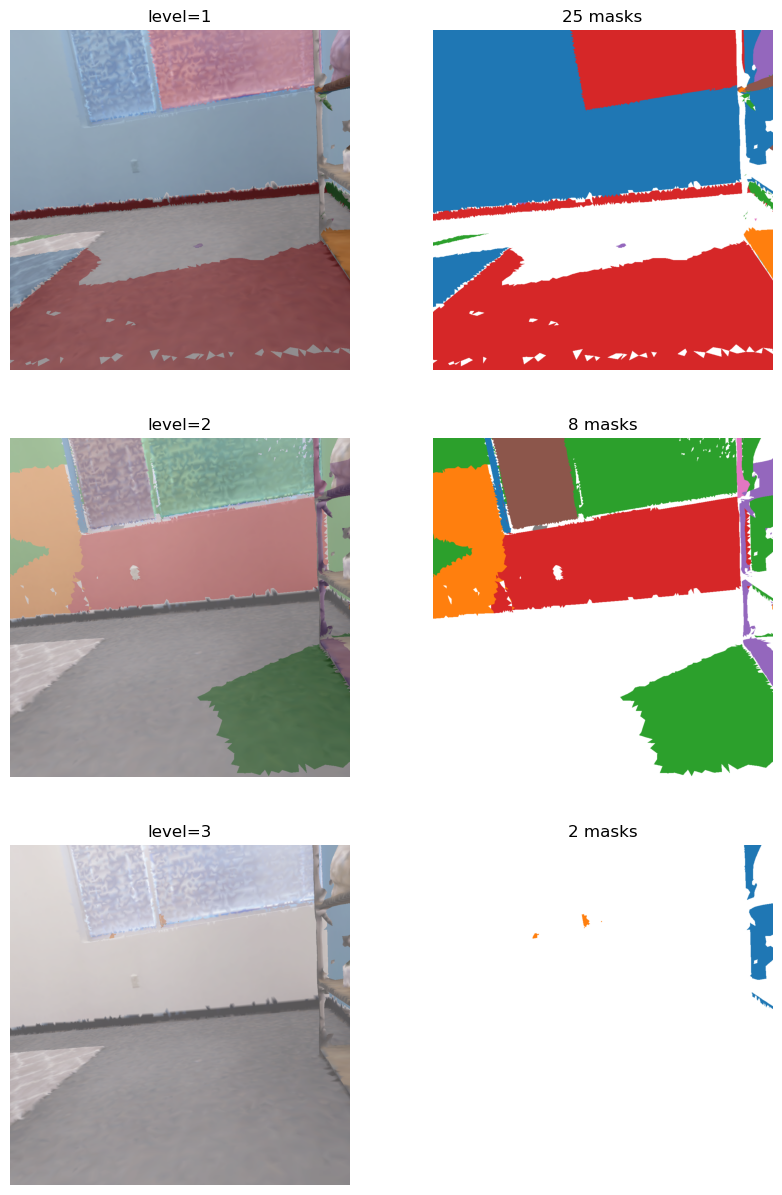

In [8]:
show_index = np.random.randint(100)
print('index:', show_index)
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])

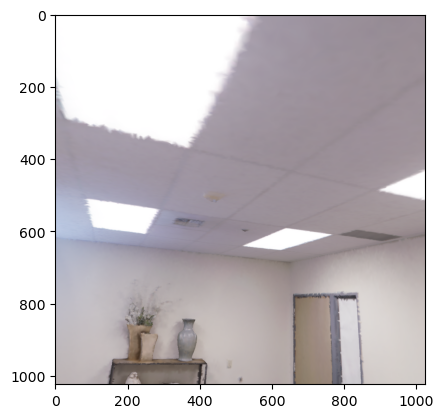

F32Tensor[1024, 1024, 3], BoolTensor[38, 1024, 1024]


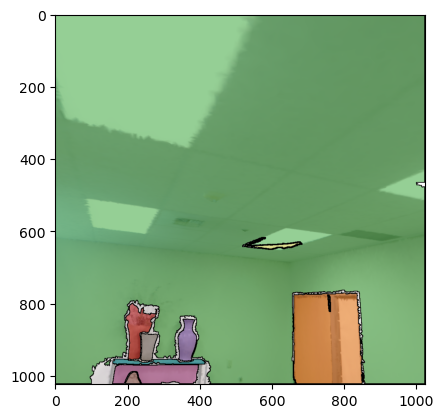

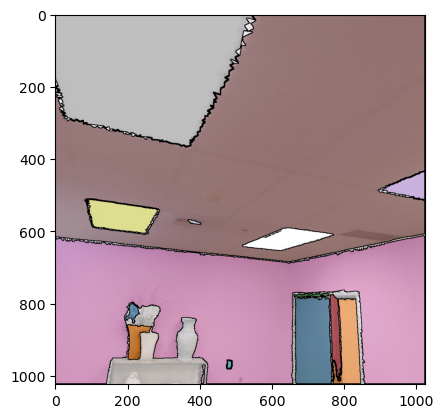

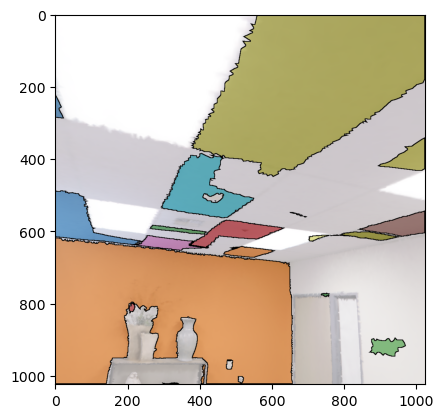

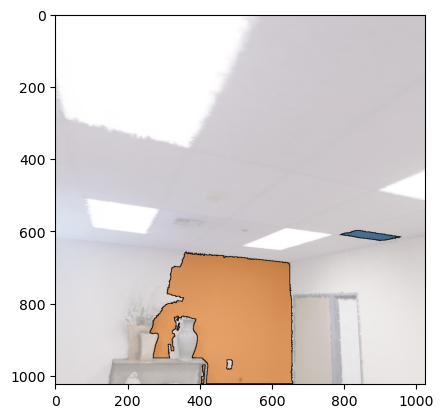

In [11]:
def save_results(index, save_dir:Path=None, alpha=0.5):
    image = images[index, :, :, :3]
    if save_dir is not None:
        save_dir.mkdir(exist_ok=True, parents=True)
        utils.save_image(save_dir.joinpath(f'view_{index}.png'), image)
    plt.imshow(image.cpu().numpy())
    plt.show()
    # return
  
    tree2d = tree3d.get_2d_tree(tri_ids[index].to(device))    
    print(utils.show_shape(image, tree2d.masks))
    image = image.cpu().numpy()
    for level, nodes in enumerate( tree2d.get_levels()):
        if level == 0:
            continue
        image_l = image.copy()
        colored_mask = ts.get_colored_masks(tree2d.masks[nodes-1])
        image_l = cv2.addWeighted(image_l, alpha, colored_mask, 1-alpha, 0)
        for x in nodes:
            p = tree2d.parent[x].item() - 1
            x = x.item() - 1
            image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[x], color=(0, 0, 0), kernel_size=5)
            # image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[p],color=(0, 0, 0),  kernel_size=9)
        if save_dir is not None:
            utils.save_image(save_dir.joinpath(f'view_{index}_l{level}.png'), image_l)
        plt.imshow(image_l)
        plt.show()


# for i in range(22):
save_results(83, cache_dir.joinpath('08_19'))
# save_results(9)